In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import keras
from PIL import Image
from imgaug import augmenters as iaa
from keras.applications.xception import Xception
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
from IPython.display import display

## Initialize

In [2]:
PATH = "awe"
TRAIN_PATH = "TrainData"
total_subjects = 100
epochs = 50 
batch_size = 128
img_size = 200
          
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load data

In [3]:
training_dataset = keras.preprocessing.image_dataset_from_directory(
    "awe\TrainData",
    labels='inferred',
    subset="training",
    seed=123,
    validation_split=0.2,                                                             
    batch_size=128,
    image_size=(img_size, img_size))

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    "awe\TrainData",
    labels='inferred',
    subset="validation",
    seed=123,
    validation_split=0.2,                                                             
    batch_size=128,
    image_size=(img_size, img_size))

Found 1000 files belonging to 100 classes.
Using 800 files for training.
Found 1000 files belonging to 100 classes.
Using 200 files for validation.


## Configure the dataset for performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
# prefetch data
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation layer

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.5),
    layers.experimental.preprocessing.RandomContrast(0.3)
])

In [6]:
nb_filters = 64
pool_size = 4
kernel_size = 10
input_shape = (img_size, img_size,1)  # dimenstion

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.5),
    layers.experimental.preprocessing.RandomContrast(0.3),
    #data_augmentation,
    layers.Conv2D(6,kernel_size,input_shape=input_shape,strides=1, activation='relu'), # conv 1
    layers.AveragePooling2D(pool_size,strides=2),
    layers.Conv2D(12,kernel_size,strides=1, activation='relu'), # conv 2
    layers.AveragePooling2D(pool_size,strides=2),
    layers.Flatten(),
    layers.Dense(total_subjects),  # num_classes
    layers.Activation('softmax') 
])


In [7]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [8]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size=128
    verbose=1,
    epochs=epochs
)

print(history.history)
print('Train loss:', history.history['loss'])
print('Train accuracy:', history.history['accuracy'])
print('Test loss:', history.history['val_loss'])
print('Test accuracy:', history.history['val_accuracy'])

Epoch 1/50
13/13 [==============================] - 7s 190ms/step - loss: 4.6599 - accuracy: 0.0049 - val_loss: 4.6117 - val_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 1s 45ms/step - loss: 4.6058 - accuracy: 0.0148 - val_loss: 4.6090 - val_accuracy: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 1s 45ms/step - loss: 4.6014 - accuracy: 0.0177 - val_loss: 4.6212 - val_accuracy: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 1s 45ms/step - loss: 4.6082 - accuracy: 0.0139 - val_loss: 4.6629 - val_accuracy: 0.0150
Epoch 5/50
13/13 [==============================] - 1s 45ms/step - loss: 4.6385 - accuracy: 0.0075 - val_loss: 4.6128 - val_accuracy: 0.0000e+00
Epoch 6/50
13/13 [==============================] - 1s 45ms/step - loss: 4.5934 - accuracy: 0.0229 - val_loss: 4.6142 - val_accuracy: 0.0000e+00
Epoch 7/50
13/13 [==============================] - 1s 44ms/step - loss: 4.5781 - accuracy: 0.0199 - val_loss: 4.6305 - val_accuracy:

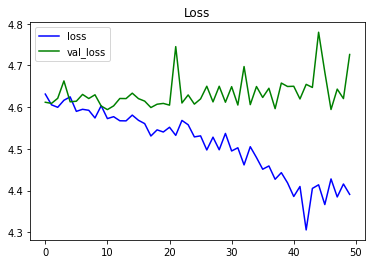

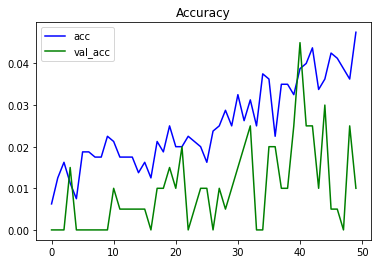

Test loss: 4.7262468338012695
Test accuracy: 0.009999999776482582


In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
x = range(len(acc))

plt.figure()
plt.title("Loss")
plt.plot(x, loss, 'b', label='loss')
plt.plot(x, val_loss, 'g', label = 'val_loss' )
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(x, acc, 'b', label='acc')
plt.plot(x, val_acc, 'g', label ='val_acc')
plt.legend()
plt.show()

model.save_weights('weights.h4')

score = model.evaluate(validation_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Xception

In [10]:
def dataset(mode): 
    total_images = []
    label =[]
    mode_path = os.path.join(PATH,mode)  # mode path -> awe/TrainData
    subjects = os.listdir(mode_path)  # 
    
    for subject in subjects:
        image_path  = os.path.join(mode_path,subject)
        images = os.listdir(image_path)
        for image in images:
            if(image.endswith(".png")):
                file = os.path.join(image_path,image)
                total_images.append(cv2.resize(cv2.imread(file),(200,200)))
                label.append(int(subject))
    total_images = np.array(total_images)
    label = np.array(label)
    return total_images , label

In [11]:
train,label = dataset('TrainData')

def split_data(data,label,valid_len):
    valid_len = int(valid_len*len(data)/100)
    return (data[0:len(data)-valid_len],label[0:len(data)-valid_len],
            data[len(data)-valid_len:len(data)],label[len(data)-valid_len:len(data)])

In [12]:
x_train,y_train,x_valid,y_valid = split_data(train,label,20)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(800, 200, 200, 3)
(200, 200, 200, 3)
(800,)
(200,)


In [13]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, total_subjects+1,dtype='int32')
y_valid = keras.utils.to_categorical(y_valid, total_subjects+1,dtype='int32')
y_train = y_train[:,0:total_subjects]
y_valid = y_valid[:,0:total_subjects]

In [14]:
base_modelX = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(x_train[0].shape))

#base_modelX.trainable = False
#inputs = keras.Input(shape=(img_size, img_size, 3))
#x = base_modelX(inputs, training=False)

x= base_modelX.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(total_subjects,activation='softmax')(x)

modelX = keras.Model(base_modelX.input, outputs)
modelX.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
for layer in base_modelX.layers:
    layer.trainable = False

In [16]:
modelX.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [17]:
historyX = modelX.fit(x_train, y_train,
          batch_size=70,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid))

print(historyX.history)
print('Train loss:', historyX.history['loss'])
print('Train accuracy:', historyX.history['accuracy'])
print('Test loss:', historyX.history['val_loss'])
print('Test accuracy:', historyX.history['val_accuracy'])

Epoch 1/50
12/12 [==============================] - 10s 521ms/step - loss: 69.9510 - accuracy: 0.0094 - val_loss: 62.7715 - val_accuracy: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 3s 236ms/step - loss: 69.8266 - accuracy: 0.0123 - val_loss: 62.6151 - val_accuracy: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 3s 236ms/step - loss: 70.1567 - accuracy: 0.0164 - val_loss: 62.4581 - val_accuracy: 0.0000e+00
Epoch 4/50
12/12 [==============================] - 3s 236ms/step - loss: 68.6211 - accuracy: 0.0161 - val_loss: 62.3003 - val_accuracy: 0.0000e+00
Epoch 5/50
12/12 [==============================] - 3s 236ms/step - loss: 66.9898 - accuracy: 0.0110 - val_loss: 62.1408 - val_accuracy: 0.0000e+00
Epoch 6/50
12/12 [==============================] - 3s 237ms/step - loss: 67.8529 - accuracy: 0.0162 - val_loss: 61.9789 - val_accuracy: 0.0000e+00
Epoch 7/50
12/12 [==============================] - 3s 237ms/step - loss: 67.4960 - accuracy: 0.0123 - val_loss

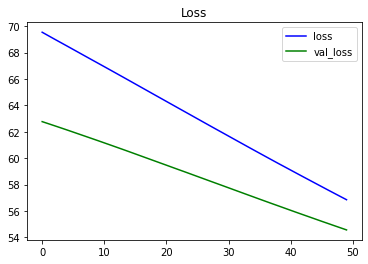

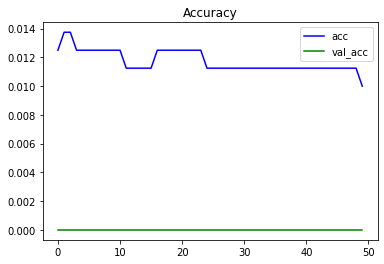

Test loss: 0.0
Test accuracy: 0.0


In [19]:
loss = historyX.history['loss']
val_loss = historyX.history['val_loss']
acc = historyX.history['accuracy']
val_acc = historyX.history['val_accuracy']
x = range(len(acc))

plt.figure()
plt.title("Loss")
plt.plot(x, loss, 'b', label='loss')
plt.plot(x, val_loss, 'g', label = 'val_loss' )
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(x, acc, 'b', label='acc')
plt.plot(x, val_acc, 'g', label ='val_acc')
plt.legend()
plt.show()



score = modelX.evaluate(x_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

